# EDA & Feature Engineering

**Goal:** Explore the clean IMDb dataset and prepare features for modeling.

**Input:** `data/movies_clean.csv` (298k movies, generated by `data_cleaning.ipynb`)

**Sections:**
1. Load Data
2. Exploratory Data Analysis
3. Feature Engineering
4. Export Wide Table

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
pd.set_option("display.max_columns", None)
plt.style.use("ggplot")
%matplotlib inline

## 1. Load Clean Data

In [99]:
# Load the clean dataset
df = pd.read_csv("../data/movies_clean.csv")

print(f"Loaded {len(df):,} movies")
display(df.head())
df.info()

Loaded 298,616 movies


,tconst,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000009,Miss Jerry,Miss Jerry,0,1894.0,45,Romance,5.2,232
1,tt0000147,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897.0,100,"Documentary,News,Sport",5.3,584
2,tt0000335,Soldiers of the Cross,Soldiers of the Cross,0,1900.0,40,"Biography,Drama",5.4,67
3,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906.0,70,"Action,Adventure,Biography",6.0,1046
4,tt0000591,The Prodigal Son,L'enfant prodigue,0,1907.0,90,Drama,4.8,37


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298616 entries, 0 to 298615
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tconst          298616 non-null  object 
 1   primaryTitle    298616 non-null  object 
 2   originalTitle   298616 non-null  object 
 3   isAdult         298616 non-null  int64  
 4   startYear       298594 non-null  float64
 5   runtimeMinutes  298616 non-null  int64  
 6   genres          298616 non-null  object 
 7   averageRating   298616 non-null  float64
 8   numVotes        298616 non-null  int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 20.5+ MB


## 2. Exploratory Data Analysis

Let's explore the data to understand patterns and distributions.

### 2.1 Ratings Distribution

What does our target variable look like? Is it normally distributed, skewed?

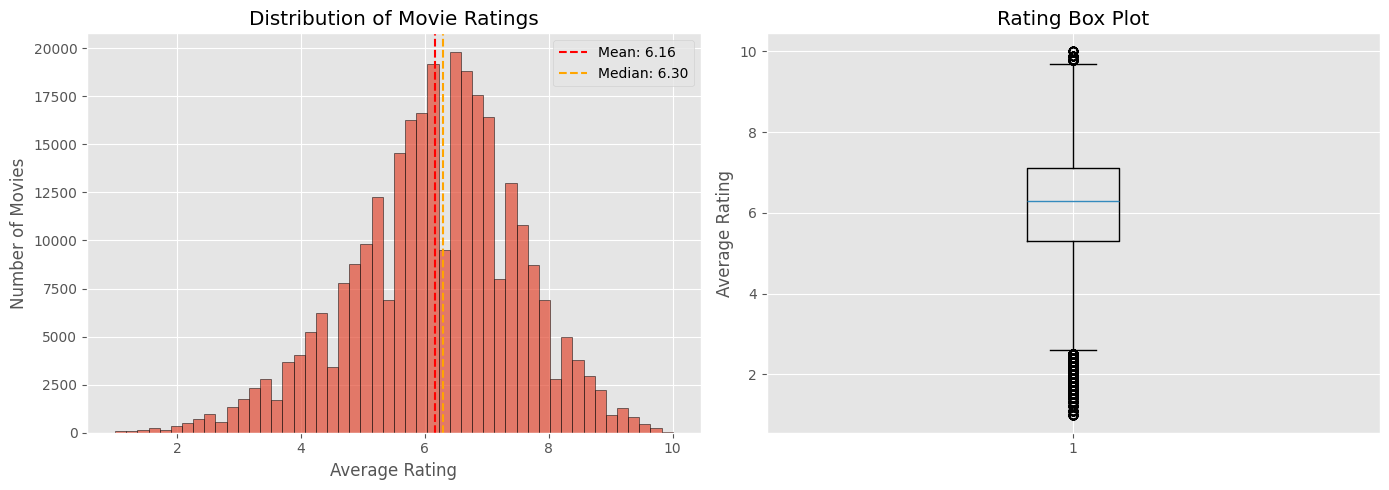

--- Rating Statistics ---
count    298616.000000
mean          6.156852
std           1.351020
min           1.000000
25%           5.300000
50%           6.300000
75%           7.100000
max          10.000000
Name: averageRating, dtype: float64


In [100]:
# Ratings distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df['averageRating'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Average Rating')
axes[0].set_ylabel('Number of Movies')
axes[0].set_title('Distribution of Movie Ratings')
axes[0].axvline(df['averageRating'].mean(), color='red', linestyle='--', label=f"Mean: {df['averageRating'].mean():.2f}")
axes[0].axvline(df['averageRating'].median(), color='orange', linestyle='--', label=f"Median: {df['averageRating'].median():.2f}")
axes[0].legend()

# Box plot
axes[1].boxplot(df['averageRating'], vert=True)
axes[1].set_ylabel('Average Rating')
axes[1].set_title('Rating Box Plot')

plt.tight_layout()
plt.show()

# Stats
print("--- Rating Statistics ---")
print(df['averageRating'].describe())

**Interpretation:**

The ratings follow a roughly normal distribution, slightly left-skewed with a peak around 6-7. The mean (6.16) and median (6.30) are close, confirming the distribution is fairly symmetric. Most movies fall between 5.3 and 7.1 (the IQR), which makes sense — truly terrible or perfect movies are rare. The box plot shows some outliers at both extremes, but nothing unusual for a rating system.

### 2.2 Genres Breakdown

Movies can have multiple genres (e.g., "Action,Comedy,Romance"). Let's see which genres are most common.

In [101]:
# Extract all genres (split comma-separated values)
all_genres = df['genres'].str.split(',').explode()
genre_counts = all_genres.value_counts()

print(f"Total unique genres: {len(genre_counts)}")
print("\n--- Genre Frequency ---")
print(genre_counts)

Total unique genres: 27

--- Genre Frequency ---
genres
Drama          142119
Comedy          75662
Documentary     50917
Romance         34021
Action          31106
Crime           27695
Thriller        26616
Horror          24236
Adventure       19040
Mystery         12791
Family          11957
Biography       10293
Fantasy          9694
History          9094
Music            8166
Sci-Fi           7555
Musical          6367
War              6355
Animation        5744
Western          4919
Sport            4040
Adult            4015
Film-Noir         877
News              668
Reality-TV         62
Talk-Show          21
Game-Show           7
Name: count, dtype: int64


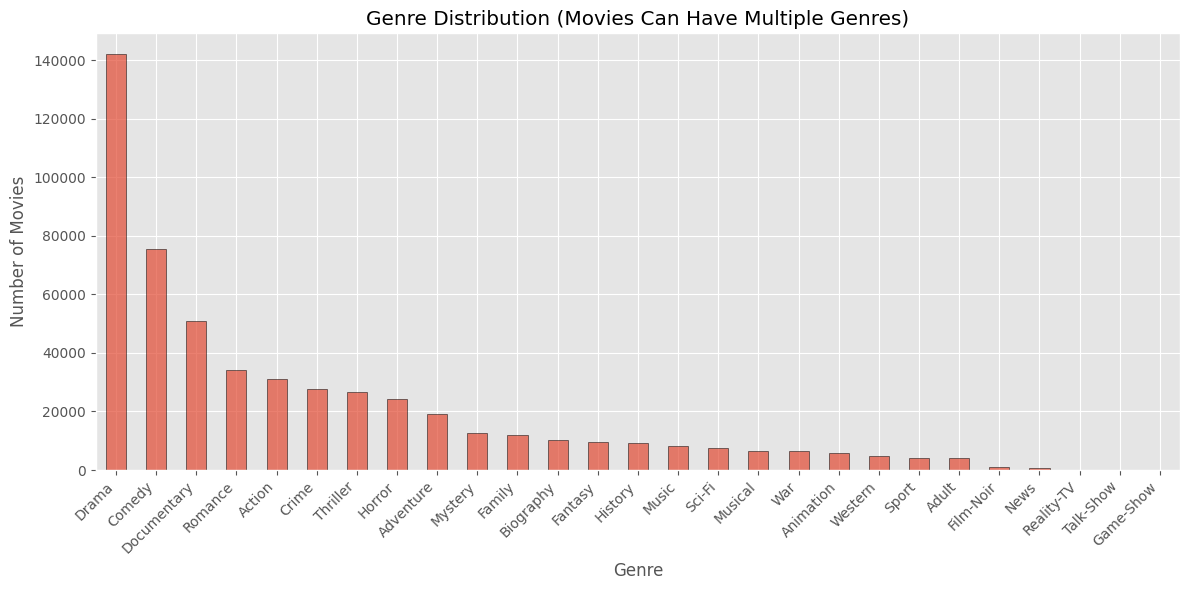

In [102]:
# Visualize genre distribution
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar', edgecolor='black', alpha=0.7)
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Genre Distribution (Movies Can Have Multiple Genres)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Interpretation:**

Drama dominates with 142k movies — nearly half the dataset includes this genre. Comedy and Documentary follow, which makes sense as these are broad, accessible categories. The long tail includes niche genres like Film-Noir (877), News (668), and Game-Show (7). 

With only 27 unique genres, one-hot encoding is feasible — we won't create hundreds of columns. The imbalance is worth noting: Drama is 200x more common than Game-Show. For modeling, we might consider grouping rare genres or focusing on the top 10-15.

### 2.3 Number of Votes Distribution

How are votes distributed? Are there many movies with very few votes?

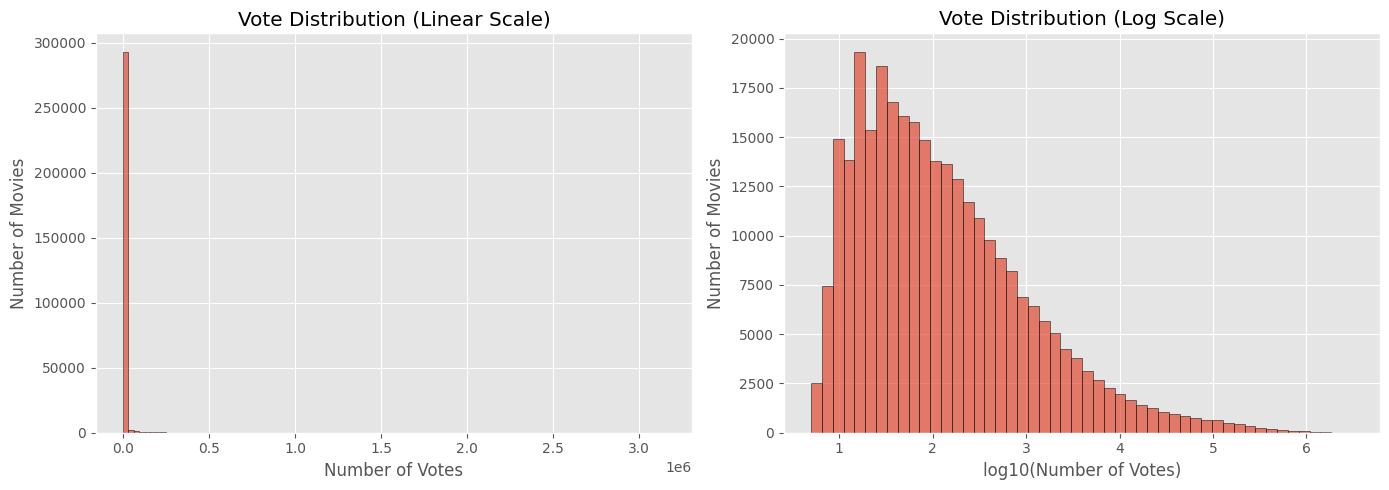

--- Vote Statistics ---
count    2.986160e+05
mean     4.182874e+03
std      4.000107e+04
min      5.000000e+00
25%      2.500000e+01
50%      8.500000e+01
75%      4.170000e+02
max      3.148583e+06
Name: numVotes, dtype: float64

Movies with < 100 votes: 158,237 (53.0%)
Movies with < 1000 votes: 251,170 (84.1%)


In [103]:
# numVotes distribution (log scale because of extreme skew)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Regular histogram (will be very skewed)
axes[0].hist(df['numVotes'], bins=100, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of Votes')
axes[0].set_ylabel('Number of Movies')
axes[0].set_title('Vote Distribution (Linear Scale)')

# Log scale
axes[1].hist(np.log10(df['numVotes']), bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('log10(Number of Votes)')
axes[1].set_ylabel('Number of Movies')
axes[1].set_title('Vote Distribution (Log Scale)')

plt.tight_layout()
plt.show()

# Stats
print("--- Vote Statistics ---")
print(df['numVotes'].describe())
print(f"\nMovies with < 100 votes: {(df['numVotes'] < 100).sum():,} ({(df['numVotes'] < 100).mean()*100:.1f}%)")
print(f"Movies with < 1000 votes: {(df['numVotes'] < 1000).sum():,} ({(df['numVotes'] < 1000).mean()*100:.1f}%)")

**Interpretation:**

The vote distribution is extremely skewed — the linear scale plot is basically a spike at zero because a few blockbusters have millions of votes while most movies have very few. The log scale reveals the true shape: a bell curve centered around 10-100 votes.

Key insight: **53% of movies have fewer than 100 votes**, and **84% have fewer than 1,000**. This raises a question for our team: should we filter to movies with a minimum vote threshold? Ratings from 10 people aren't statistically reliable. This could be a decision point for the modeling phase.

### 2.4 Runtime Distribution

How long are movies typically? Are there outliers?

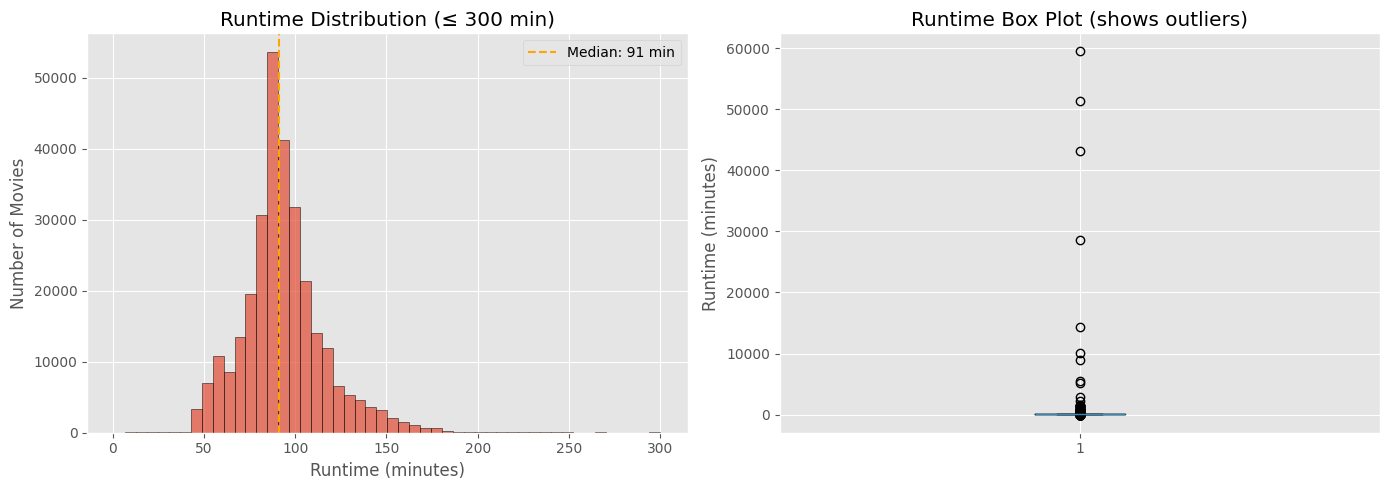

--- Runtime Statistics ---
count    298616.000000
mean         94.630231
std         178.263758
min           1.000000
25%          81.000000
50%          91.000000
75%         103.000000
max       59460.000000
Name: runtimeMinutes, dtype: float64

Movies > 3 hours (180 min): 1,620
Movies > 5 hours (300 min): 226


In [104]:
# Convert runtimeMinutes to numeric (it might be stored as string)
df['runtimeMinutes'] = pd.to_numeric(df['runtimeMinutes'], errors='coerce')

# Runtime distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram (filter to reasonable range for visualization)
reasonable_runtime = df[df['runtimeMinutes'] <= 300]['runtimeMinutes']
axes[0].hist(reasonable_runtime, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Runtime (minutes)')
axes[0].set_ylabel('Number of Movies')
axes[0].set_title('Runtime Distribution (≤ 300 min)')
axes[0].axvline(df['runtimeMinutes'].median(), color='orange', linestyle='--', label=f"Median: {df['runtimeMinutes'].median():.0f} min")
axes[0].legend()

# Box plot
axes[1].boxplot(df['runtimeMinutes'].dropna(), vert=True)
axes[1].set_ylabel('Runtime (minutes)')
axes[1].set_title('Runtime Box Plot (shows outliers)')

plt.tight_layout()
plt.show()

# Stats
print("--- Runtime Statistics ---")
print(df['runtimeMinutes'].describe())
print(f"\nMovies > 3 hours (180 min): {(df['runtimeMinutes'] > 180).sum():,}")
print(f"Movies > 5 hours (300 min): {(df['runtimeMinutes'] > 300).sum():,}")

**Interpretation:**

The typical movie is about 90 minutes (median: 91 min), which aligns with industry standards. The distribution is right-skewed with a peak around 90-100 minutes. Most movies (IQR) fall between 81 and 103 minutes.

However, there are extreme outliers — the max is 59,460 minutes (that's 41 days!). These are likely data errors or experimental films. There are 226 movies over 5 hours, which we might want to investigate or cap. For feature engineering, we could consider binning runtime into categories (short/medium/long) or capping extreme values.

### 2.5 Genres per Movie

How many genres does a typical movie have?

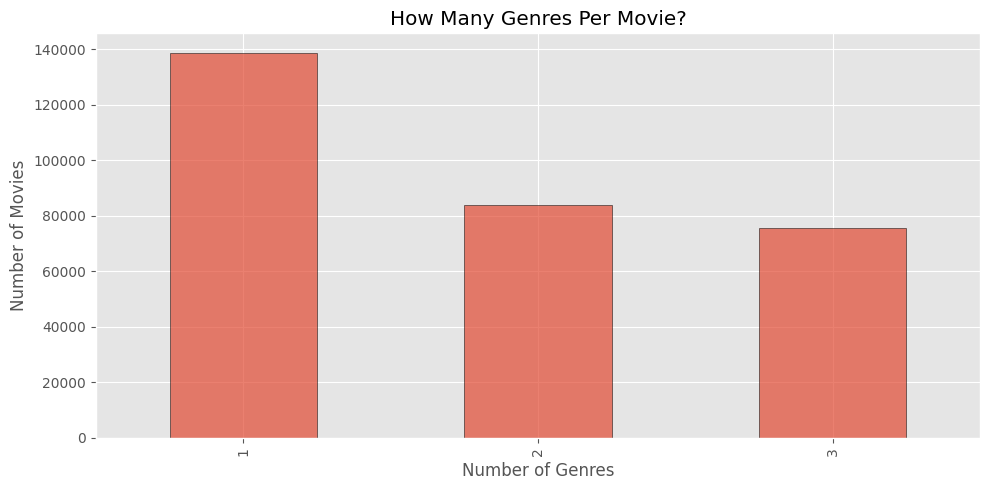

--- Genres per Movie ---
genre_count
1    138860
2     84091
3     75665
Name: count, dtype: int64


In [105]:
# Count genres per movie
df['genre_count'] = df['genres'].str.split(',').str.len()

plt.figure(figsize=(10, 5))
df['genre_count'].value_counts().sort_index().plot(kind='bar', edgecolor='black', alpha=0.7)
plt.xlabel('Number of Genres')
plt.ylabel('Number of Movies')
plt.title('How Many Genres Per Movie?')
plt.tight_layout()
plt.show()

print("--- Genres per Movie ---")
print(df['genre_count'].value_counts().sort_index())

**Interpretation:**

Most movies have 1-3 genres, with single-genre movies being the most common (139k). Very few movies have more than 3 genres assigned. This is good news for feature engineering — when we one-hot encode genres, most rows will have 1-3 columns set to 1, keeping the data relatively sparse and manageable.

The `genre_count` feature itself might be useful for modeling — perhaps movies with more genres are harder to categorize and receive different ratings?

### 2.6 Adult Content Flag

How many movies are flagged as adult content? Do they have different rating patterns?

--- Adult Content Flag ---
isAdult
0    294590
1      4026
Name: count, dtype: int64

Adult films: 4,026 (1.35%)


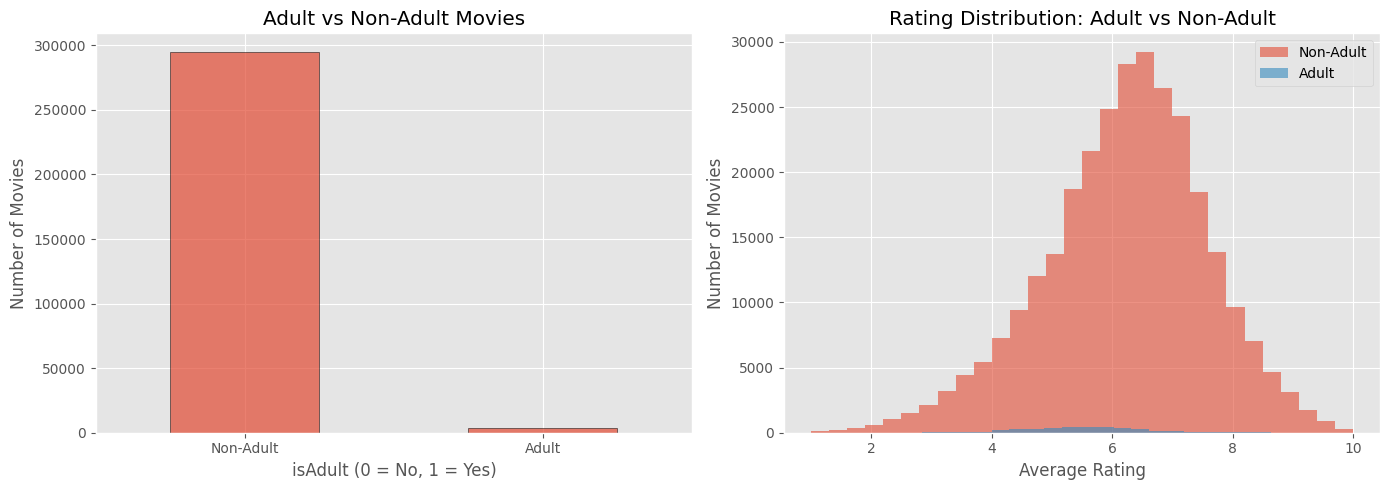


--- Rating Comparison ---
            count      mean       std  min  25%  50%  75%   max
isAdult                                                        
0        294590.0  6.165461  1.352004  1.0  5.4  6.3  7.1  10.0
1          4026.0  5.526875  1.108433  1.1  4.8  5.6  6.2   9.8


In [106]:
# isAdult distribution
print("--- Adult Content Flag ---")
print(df['isAdult'].value_counts())
print(f"\nAdult films: {df['isAdult'].sum():,} ({df['isAdult'].mean()*100:.2f}%)")

# Compare ratings
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of counts
df['isAdult'].value_counts().plot(kind='bar', ax=axes[0], edgecolor='black', alpha=0.7)
axes[0].set_xlabel('isAdult (0 = No, 1 = Yes)')
axes[0].set_ylabel('Number of Movies')
axes[0].set_title('Adult vs Non-Adult Movies')
axes[0].set_xticklabels(['Non-Adult', 'Adult'], rotation=0)

# Rating comparison
df.groupby('isAdult')['averageRating'].plot(kind='hist', ax=axes[1], alpha=0.6, bins=30, legend=True)
axes[1].set_xlabel('Average Rating')
axes[1].set_ylabel('Number of Movies')
axes[1].set_title('Rating Distribution: Adult vs Non-Adult')
axes[1].legend(['Non-Adult', 'Adult'])

plt.tight_layout()
plt.show()

# Stats comparison
print("\n--- Rating Comparison ---")
print(df.groupby('isAdult')['averageRating'].describe())

**Interpretation:**

Adult films are a tiny fraction of the dataset (1.35%, ~4k movies). Interestingly, they show a lower average rating (5.53) compared to non-adult films (6.17), and with less variance (std 1.11 vs 1.35). While rare, this flag seems to carry a distinct signal for ratings.

### 2.7 Release Year Distribution

When were these movies released? How has movie production changed over time?

--- Release Year Statistics ---
count    298594.000000
mean       1997.457551
std          25.977020
min        1894.000000
25%        1982.000000
50%        2008.000000
75%        2017.000000
max        2026.000000
Name: startYear, dtype: float64


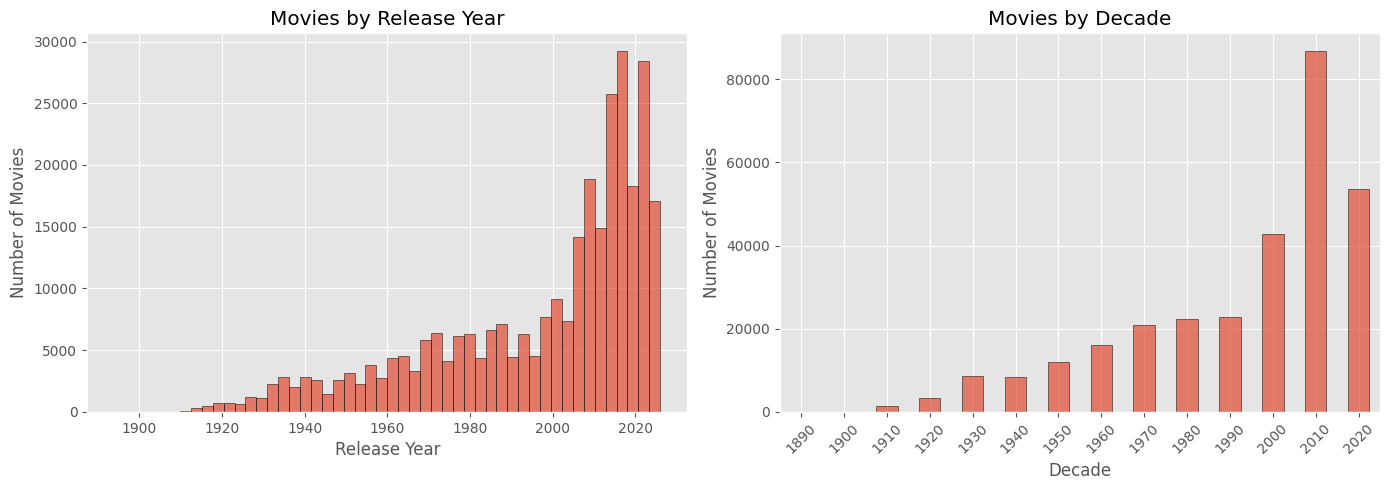


--- Movies by Decade ---
decade
1890        4
1900       20
1910     1324
1920     3236
1930     8659
1940     8417
1950    11902
1960    15956
1970    20811
1980    22231
1990    22922
2000    42749
2010    86703
2020    53660
Name: count, dtype: Int64


In [107]:
# Year distribution
print("--- Release Year Statistics ---")
print(df['startYear'].describe())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram by year
axes[0].hist(df['startYear'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Release Year')
axes[0].set_ylabel('Number of Movies')
axes[0].set_title('Movies by Release Year')

# By decade (cleaner view)
df['decade'] = (df['startYear'] // 10 * 10).astype('Int64')
decade_counts = df['decade'].value_counts().sort_index()
decade_counts.plot(kind='bar', ax=axes[1], edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Decade')
axes[1].set_ylabel('Number of Movies')
axes[1].set_title('Movies by Decade')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n--- Movies by Decade ---")
print(decade_counts)

**Interpretation:**

**Recency Bias:** The dataset is heavily skewed towards modern cinema. The median release year is 2008, meaning half of the movies in this dataset were released in the last ~18 years.

**Exponential Growth:** We see a massive jump in movie volume starting in the 1990s and exploding in the 2000s/2010s. The 2010s alone account for 86k movies.

**Implication:** Our model will likely be biased towards modern movie preferences. We should consider using `releaseYear` or `decade` as features to account for these trends.

### 2.8 EDA Summary & Strategic Plan

Based on our exploration, here is the roadmap for Feature Engineering:

**1. Target Variable (`averageRating`)**
*   **Insight:** Normal distribution (mean ~6.2), slight left skew.
*   **Action:** No transformation needed.

**2. Popularity (`numVotes`)**
*   **Insight:** Massive skew. A few blockbusters have millions of votes; most have < 100.
*   **Action:**
    *   **Log Transformation:** Apply `np.log10` or `np.log1p` to normalize the range.
    *   **Thresholding:** Discuss applying a minimum vote threshold (e.g., exclude movies with < 10 or < 50 votes) to remove unreliable ratings (noise).

**3. Genres (Detailed Strategy)**
*   **Insight:** Multi-label data (e.g., "Action,Comedy"). 27 unique genres total. Rare genres (Game-Show, News) appear < 100 times.
*   **Action:**
    *   **Multi-Label Binarization:** Create binary columns for each genre (`Genre_Action`, `Genre_Comedy`, etc.).
    *   **Pruning:** Drop genres with **< 1,000 occurrences**. These are statistical noise and risk overfitting.
    *   **New Feature:** Introduce `genre_count` (which we calculated during EDA) as a permanent feature to capture movie complexity/niche appeal.

**4. Runtime**
*   **Insight:** Outliers exist (up to 41 days).
*   **Action:** **Winsorize/Cap** runtime (e.g., at the **99th percentile** or ~300 minutes) to prevent outliers from distorting the model.

**5. Temporal Features**
*   **Insight:** Strong recency bias.
*   **Action:** Create `movie_age` (2026 - startYear) and `decade` bins to capture era-specific rating trends.

**6. Adult Content**
*   **Insight:** Rare but correlates with lower ratings.
*   **Action:** Keep as a simple binary feature.

## 3. Feature Engineering

Transform the data into features ready for ML models.

Following the strategy defined in Section 2.8, we will now transform our raw data into model-ready features. We'll tackle this in three stages:
1.  **Temporal & Numerical Cleaning:** Handling years and runtime outliers.
2.  **Popularity Transformations:** Addressing the vote skew.
3.  **Genre Encoding:** The detailed multi-label binarization.

### 3.1 Temporal Features & Runtime Adjustment

In [108]:
# Create a copy for feature engineering
df_fe = df.copy()

# 1. Temporal Features
# Age of the movie relative to current year (2026)
df_fe['movie_age'] = 2026 - df_fe['startYear']

# Decade (e.g., 1995 -> 1990)
df_fe['decade'] = (df_fe['startYear'] // 10 * 10).astype('Int64')

# 2. Runtime Capping (Winsorization)
# Let's look at the top percentiles to decide on a cap
p99 = df_fe['runtimeMinutes'].quantile(0.99)
p995 = df_fe['runtimeMinutes'].quantile(0.995)
p999 = df_fe['runtimeMinutes'].quantile(0.999)

print(f"--- Runtime Percentiles ---")
print(f"99.0th percentile: {p99:.0f} min")
print(f"99.5th percentile: {p995:.0f} min")
print(f"99.9th percentile: {p999:.0f} min")

# Decision: Cap at 300 minutes (5 hours) to catch errors but keep long epics
runtime_cap = 300
df_fe['runtimeMinutes_capped'] = df_fe['runtimeMinutes'].clip(upper=runtime_cap)

# Verify changes
print(f"Decision: Capping runtime at {runtime_cap} minutes")
print(f"Movies capped: {(df_fe['runtimeMinutes'] > runtime_cap).sum():,}")

print("--- Feature Verification ---")
display(df_fe[['primaryTitle', 'startYear', 'movie_age', 'decade', 'runtimeMinutes', 'runtimeMinutes_capped']].head())

--- Runtime Percentiles ---
99.0th percentile: 168 min
99.5th percentile: 183 min
99.9th percentile: 285 min
Decision: Capping runtime at 300 minutes
Movies capped: 226
--- Feature Verification ---


,primaryTitle,startYear,movie_age,decade,runtimeMinutes,runtimeMinutes_capped
0,Miss Jerry,1894.0,132.0,1890,45,45
1,The Corbett-Fitzsimmons Fight,1897.0,129.0,1890,100,100
2,Soldiers of the Cross,1900.0,126.0,1900,40,40
3,The Story of the Kelly Gang,1906.0,120.0,1900,70,70
4,The Prodigal Son,1907.0,119.0,1900,90,90


### 3.2 Popularity Transformation

As seen in the EDA, `numVotes` is extremely right-skewed. We will apply a log transformation to compress the range and make the distribution more suitable for modeling.

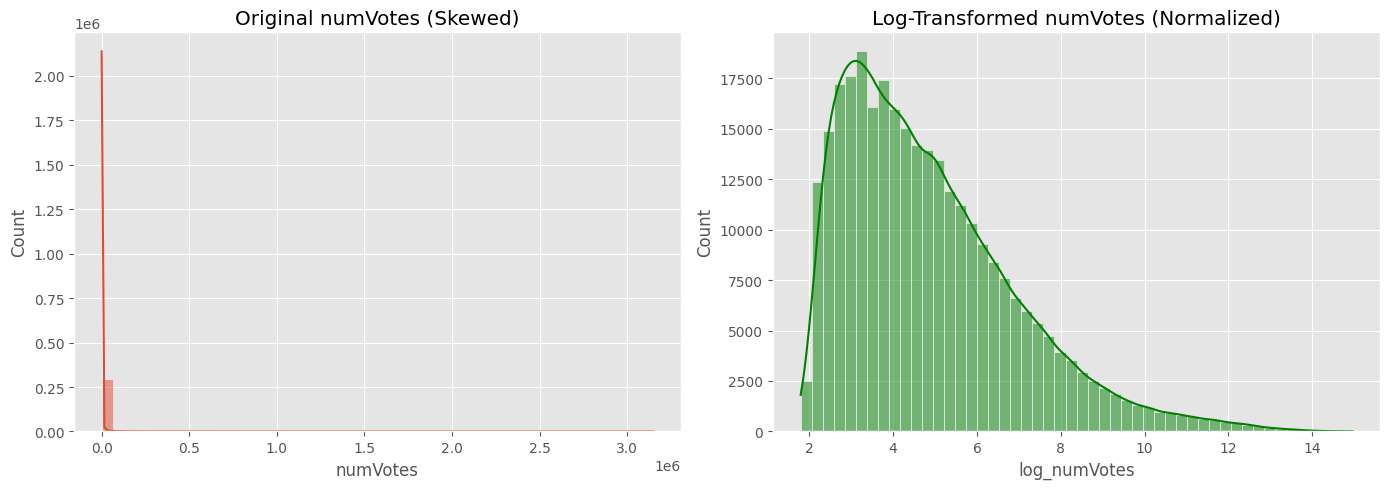

Original Skew: 26.93
Log-Transformed Skew: 1.06


In [109]:
import numpy as np

# Apply Log1p transformation (log(1+x))
# This is a standard way to handle skewed positive data
df_fe['log_numVotes'] = np.log1p(df_fe['numVotes'])

# Visualize the change
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df_fe['numVotes'], bins=50, ax=axes[0], kde=True)
axes[0].set_title('Original numVotes (Skewed)')

sns.histplot(df_fe['log_numVotes'], bins=50, ax=axes[1], kde=True, color='green')
axes[1].set_title('Log-Transformed numVotes (Normalized)')

plt.tight_layout()
plt.show()

print(f"Original Skew: {df_fe['numVotes'].skew():.2f}")
print(f"Log-Transformed Skew: {df_fe['log_numVotes'].skew():.2f}")

In [110]:
# Create 'hit' feature: 1 if movie is in top 20% by votes, 0 otherwise
percentile_80 = df_fe['numVotes'].quantile(0.80)

df_fe['hit'] = (df_fe['numVotes'] >= percentile_80).astype(int)

print(f"--- 'hit' Feature ---")
print(f"Threshold (80th percentile): {percentile_80:,.0f} votes")
print(f"Hit movies: {df_fe['hit'].sum():,} ({df_fe['hit'].mean()*100:.1f}%)")
print(f"Non-hit movies: {(df_fe['hit'] == 0).sum():,} ({(df_fe['hit'] == 0).mean()*100:.1f}%)")

--- 'hit' Feature ---
Threshold (80th percentile): 648 votes
Hit movies: 59,778 (20.0%)
Non-hit movies: 238,838 (80.0%)


### 3.3 Genre Encoding (Multi-Label Binarization)

This is the most involved transformation. We need to:
1. Identify genres with sufficient occurrences (≥ 1,000)
2. Create binary columns for each valid genre
3. Drop rare genres that would add noise

In [111]:
# Step 1: Identify genres to keep (>= 1000 occurrences)
all_genres = df_fe['genres'].str.split(',').explode()
genre_counts = all_genres.value_counts()

# Filter to genres with >= 1000 occurrences
min_occurrences = 1000
valid_genres = genre_counts[genre_counts >= min_occurrences].index.tolist()

print(f"Keeping {len(valid_genres)} genres (dropping {len(genre_counts) - len(valid_genres)} rare ones)")
print(f"\nDropped genres: {sorted(set(genre_counts.index) - set(valid_genres))}")
print(f"\nValid genres: {valid_genres}")

Keeping 22 genres (dropping 5 rare ones)

Dropped genres: ['Film-Noir', 'Game-Show', 'News', 'Reality-TV', 'Talk-Show']

Valid genres: ['Drama', 'Comedy', 'Documentary', 'Romance', 'Action', 'Crime', 'Thriller', 'Horror', 'Adventure', 'Mystery', 'Family', 'Biography', 'Fantasy', 'History', 'Music', 'Sci-Fi', 'Musical', 'War', 'Animation', 'Western', 'Sport', 'Adult']


In [112]:
# Step 2: Create binary columns for each valid genre
for genre in valid_genres:
    df_fe[f'Genre_{genre}'] = df_fe['genres'].str.contains(genre, regex=False).astype(int)

# Verify: check a movie with multiple genres
sample_movie = df_fe[df_fe['genres'] == 'Action,Adventure,Biography'].head(1)
print("Sample movie (Action,Adventure,Biography):")
genre_cols = [col for col in df_fe.columns if col.startswith('Genre_')]
display(sample_movie[['primaryTitle', 'genres'] + genre_cols])

print(f"\n--- Genre columns created: {len(genre_cols)} ---")

Sample movie (Action,Adventure,Biography):


,primaryTitle,genres,Genre_Drama,Genre_Comedy,Genre_Documentary,Genre_Romance,Genre_Action,Genre_Crime,Genre_Thriller,Genre_Horror,Genre_Adventure,Genre_Mystery,Genre_Family,Genre_Biography,Genre_Fantasy,Genre_History,Genre_Music,Genre_Sci-Fi,Genre_Musical,Genre_War,Genre_Animation,Genre_Western,Genre_Sport,Genre_Adult
3,The Story of the Kelly Gang,"Action,Adventure,Biography",0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0



--- Genre columns created: 22 ---


In [113]:
# Step 3: Verify genre_count is already present (from EDA)
# and check final feature set
print("--- Feature Engineering Summary ---")
print(f"Original columns: {len(df.columns)}")
print(f"New columns: {len(df_fe.columns)}")
print(f"\nNew features added:")
new_cols = set(df_fe.columns) - set(df.columns)
for col in sorted(new_cols):
    print(f"  - {col}")

print(f"\nDataFrame shape: {df_fe.shape}")

--- Feature Engineering Summary ---
Original columns: 11
New columns: 37

New features added:
  - Genre_Action
  - Genre_Adult
  - Genre_Adventure
  - Genre_Animation
  - Genre_Biography
  - Genre_Comedy
  - Genre_Crime
  - Genre_Documentary
  - Genre_Drama
  - Genre_Family
  - Genre_Fantasy
  - Genre_History
  - Genre_Horror
  - Genre_Music
  - Genre_Musical
  - Genre_Mystery
  - Genre_Romance
  - Genre_Sci-Fi
  - Genre_Sport
  - Genre_Thriller
  - Genre_War
  - Genre_Western
  - hit
  - log_numVotes
  - movie_age
  - runtimeMinutes_capped

DataFrame shape: (298616, 37)


## 4. Export Wide Table

In [114]:
# Select columns for the wide table (model-ready features)
# Drop: tconst (ID), primaryTitle/originalTitle (text), genres (raw string - we have one-hot now)

columns_to_drop = ['tconst', 'primaryTitle', 'originalTitle', 'genres', 'runtimeMinutes']  # keep capped version
df_wide = df_fe.drop(columns=columns_to_drop)

# Reorder: target variable first, then features
target = 'averageRating'
feature_cols = [col for col in df_wide.columns if col != target]
df_wide = df_wide[[target] + feature_cols]

print("--- Wide Table for Modeling ---")
print(f"Shape: {df_wide.shape}")
print(f"Target: {target}")
print(f"Features: {len(feature_cols)}")
print(f"\nColumns:")
print(df_wide.columns.tolist())

display(df_wide.head())

--- Wide Table for Modeling ---
Shape: (298616, 32)
Target: averageRating
Features: 31

Columns:
['averageRating', 'isAdult', 'startYear', 'numVotes', 'genre_count', 'decade', 'movie_age', 'runtimeMinutes_capped', 'log_numVotes', 'hit', 'Genre_Drama', 'Genre_Comedy', 'Genre_Documentary', 'Genre_Romance', 'Genre_Action', 'Genre_Crime', 'Genre_Thriller', 'Genre_Horror', 'Genre_Adventure', 'Genre_Mystery', 'Genre_Family', 'Genre_Biography', 'Genre_Fantasy', 'Genre_History', 'Genre_Music', 'Genre_Sci-Fi', 'Genre_Musical', 'Genre_War', 'Genre_Animation', 'Genre_Western', 'Genre_Sport', 'Genre_Adult']


,averageRating,isAdult,startYear,numVotes,genre_count,decade,movie_age,runtimeMinutes_capped,log_numVotes,hit,Genre_Drama,Genre_Comedy,Genre_Documentary,Genre_Romance,Genre_Action,Genre_Crime,Genre_Thriller,Genre_Horror,Genre_Adventure,Genre_Mystery,Genre_Family,Genre_Biography,Genre_Fantasy,Genre_History,Genre_Music,Genre_Sci-Fi,Genre_Musical,Genre_War,Genre_Animation,Genre_Western,Genre_Sport,Genre_Adult
0,5.2,0,1894.0,232,1,1890,132.0,45,5.451038,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5.3,0,1897.0,584,3,1890,129.0,100,6.371612,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,5.4,0,1900.0,67,2,1900,126.0,40,4.219508,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,6.0,0,1906.0,1046,3,1900,120.0,70,6.953684,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,4.8,0,1907.0,37,1,1900,119.0,90,3.637586,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [115]:
# Export to CSV
output_path = "../data/movies_wide.csv"
df_wide.to_csv(output_path, index=False)

print(f"Exported wide table to: {output_path}")
print(f"File size: {pd.read_csv(output_path).memory_usage(deep=True).sum() / 1e6:.1f} MB (in memory)")

Exported wide table to: ../data/movies_wide.csv
File size: 76.4 MB (in memory)
